GP Regression with GPflow
--

*James Hensman, 2015, 2016*

GP regression (with Gaussian noise) is the most straightforward GP model in GPflow. Because of the conjugacy of the latent process and the noise, the marginal likelihood $p(\mathbf y\,|\,\theta)$ can be computed exactly.

This notebook shows how to build a GPR model, estimate the parameters $\theta$ by both maximum likelihood and MCMC. 

In [1]:
import GPflow
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

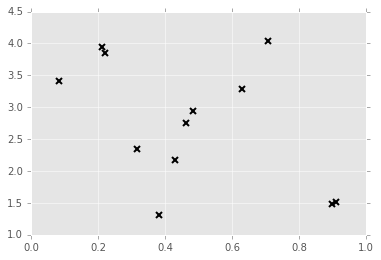

In [2]:
# build a very simple data set:
N = 12
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
plt.figure()
plt.plot(X, Y, 'kx', mew=2)

Maximum Likelihood estimation
--

In [3]:
#build the GPR object
k = GPflow.kernels.Matern52(1, lengthscales=0.3)
meanf = GPflow.mean_functions.Linear(1,0)
m = GPflow.gpr.GPR(X, Y, k, meanf)
m.likelihood.variance = 0.01

In [4]:
print "Here are the parameters before optimization"
m

Here are the parameters before optimization


Name,values,prior,constraint
model.mean_function.A,[[ 1.]],None,(none)
model.mean_function.b,[ 0.],None,(none)
model.kern.variance,[ 1.],None,+ve
model.kern.lengthscales,[ 0.3],None,+ve
model.likelihood.variance,[ 0.01],None,+ve


In [5]:
m.optimize()
print "Here are the parameters after optimization"
m

compiling tensorflow function...
done
optimization terminated, setting model state
Here are the parameters after optimization


Name,values,prior,constraint
model.mean_function.A,[[-1.36089912]],None,(none)
model.mean_function.b,[ 3.52711172],None,(none)
model.kern.variance,[ 0.75930746],None,+ve
model.kern.lengthscales,[ 0.0851984],None,+ve
model.likelihood.variance,[ 1.00023469e-06],None,+ve


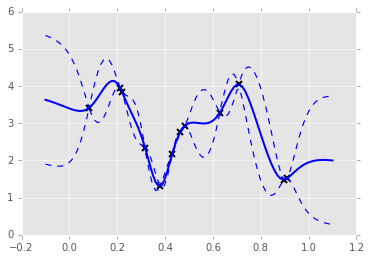

In [6]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)


MCMC
--
First, we'll set come priors on the kernel parameters, then we'll run mcmc and see how much posterior uncertainty there is in the parameters.

In [7]:
#we'll choose rather arbitrary priors. 
m.kern.lengthscales.prior = GPflow.priors.Gamma(1., 1.)
m.kern.variance.prior = GPflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = GPflow.priors.Gamma(1., 1.)
m.mean_function.A.prior = GPflow.priors.Gaussian(0., 10.)
m.mean_function.b.prior = GPflow.priors.Gaussian(0., 10.)
m

Name,values,prior,constraint
model.mean_function.A,[[-1.36089912]],"N([ 0.],[ 10.])",(none)
model.mean_function.b,[ 3.52711172],"N([ 0.],[ 10.])",(none)
model.kern.variance,[ 0.75930746],"Ga([ 1.],[ 1.])",+ve
model.kern.lengthscales,[ 0.0851984],"Ga([ 1.],[ 1.])",+ve
model.likelihood.variance,[ 1.00023469e-06],"Ga([ 1.],[ 1.])",+ve


In [8]:
samples = m.sample(500, epsilon=0.2, verbose=1)

compiling tensorflow function...
done
Iteration:  100 	 Acc Rate:  82.0 %
Iteration:  200 	 Acc Rate:  92.0 %
Iteration:  300 	 Acc Rate:  90.0 %
Iteration:  400 	 Acc Rate:  94.0 %
Iteration:  500 	 Acc Rate:  94.0 %


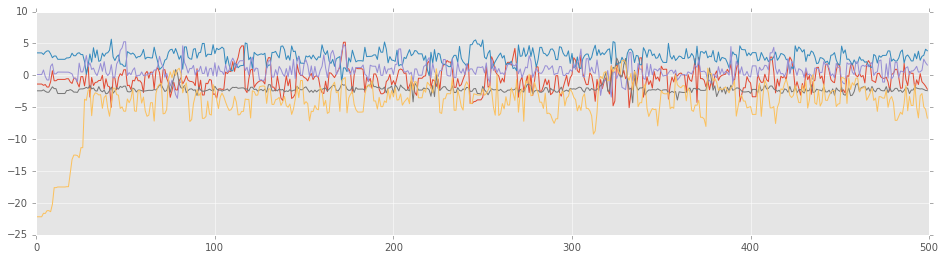

In [9]:
plt.figure(figsize=(16, 4))
plt.plot(samples)

In [12]:
# convert the samples into a nice DataFrame
sample_df = m.get_samples_df(samples)
sample_df.head()

,model.mean_function.A,model.mean_function.b,model.kern.variance,model.kern.lengthscales,model.likelihood.variance
0,-1.36089912331,3.52711171598,0.759307458159,0.0851983991802,1.00023469293e-06
1,-1.36089912331,3.52711171598,0.759307458159,0.0851983991802,1.00023469293e-06
2,-1.36089912331,3.52711171598,0.759307458159,0.0851983991802,1.00023469293e-06
3,-1.36089912331,3.52711171598,0.759307458159,0.0851983991802,1.00023469293e-06
4,-1.56422793288,3.27643324539,1.20430632387,0.0981570628024,1.00040859538e-06


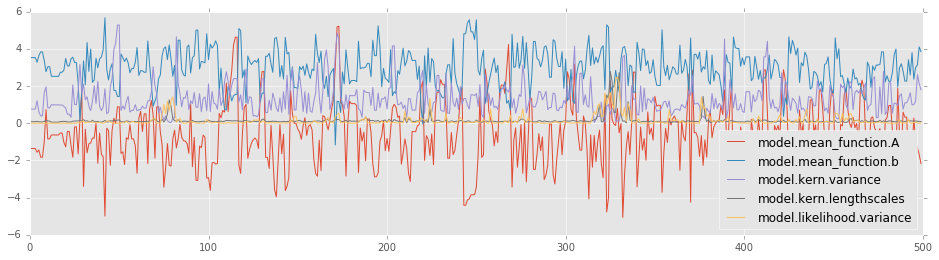

In [13]:
# make a more informative plot
plt.figure(figsize=(16, 4))
for lab, s in sample_df.iteritems():
    plt.plot(s, label=lab)
plt.legend(loc=0)

(-0.10000000000000001, 1.1000000000000001)

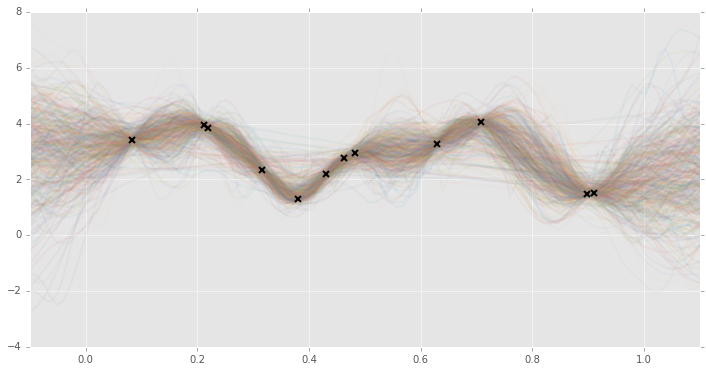

In [31]:
#plot the function posterior
plt.figure(figsize=(12, 6))

for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    f = m.predict_f_samples(xx, 1)
    plt.plot(xx, f[0,:,:], lw=2, alpha = 0.05)
    
plt.plot(X, Y, 'kx', mew=2)
plt.xlim(xx.min(), xx.max())

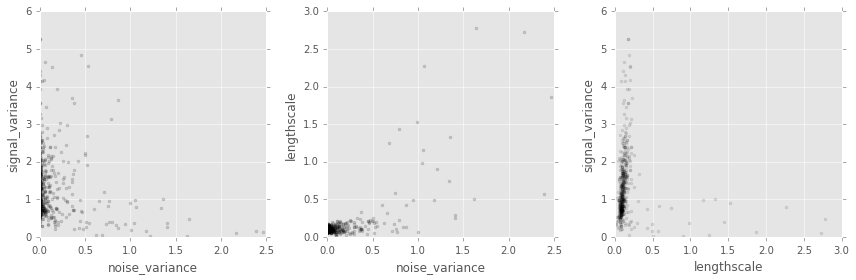

In [16]:
f, axs = plt.subplots(1,3, figsize=(12,4), tight_layout=True)

axs[0].plot(sample_df['model.likelihood.variance'],
            sample_df['model.kern.variance'], 'k.', alpha = 0.15)
axs[0].set_xlabel('noise_variance')
axs[0].set_ylabel('signal_variance')

axs[1].plot(sample_df['model.likelihood.variance'],
            sample_df['model.kern.lengthscales'], 'k.', alpha = 0.15)
axs[1].set_xlabel('noise_variance')
axs[1].set_ylabel('lengthscale')

axs[2].plot(sample_df['model.kern.lengthscales'],
            sample_df['model.kern.variance'], 'k.', alpha = 0.1)
axs[2].set_xlabel('lengthscale')
axs[2].set_ylabel('signal_variance')